# Scoring Forecast models
This notebook explains how the `Scorer` class can be used to compute the following metrics: 
* MAE (mean absolute error); 
* MSE (mean squared error); 
* CRPS (Continuous Ranked Probability Score);
* Log Score.
* Interval Score

The CRPS and Log score assume a normal distribution. 

To see the plots below as interactive charts use `alt.renderers.enable("default")`

In [1]:
import altair as alt 
alt.renderers.enable("png")

RendererRegistry.enable('png')

In [2]:
import numpy as np
import pandas as pd
from mosqlient import get_infodengue
from mosqlient.models.score import Scorer

To show the use of the class to compare the score of new predictions with the predictions registered on the platform it will be used the baseline model.

In [3]:
from datetime import date
from mosqlient.datastore import Infodengue
from mosqlient.models.baseline import Arima

It will compare the predictions of id 77 and 78, which refer to the geocode 3304557, between `2022-01-02` and `2023-06-25`. 

So initially, we will get the data that will be used to train the model and generate the new predictions:

In [4]:
disease = 'dengue'
geocode = 3304557 
end_date = date.today().strftime('%Y-%m-%d')

df = get_infodengue(disease = 'dengue',
                start_date = '2010-01-01', 
              end_date = '2023-12-31', 
              geocode = 3304557)

df['data_iniSE'] = pd.to_datetime(df['data_iniSE'])

df.set_index('data_iniSE', inplace = True )
    
df = df[['casos']].rename(columns = {'casos':'y'})

df = df.resample('W-SUN').sum()

df.head()

,y
data_iniSE,
2010-01-03,30
2010-01-10,44
2010-01-17,46
2010-01-24,47
2010-01-31,68


Create the model:

In [6]:
m_arima = Arima(df = df)

m_arima

Train the model: 

In [7]:
model = m_arima.train(train_ini_date='2010-01-01', train_end_date = '2021-12-31')


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-292.056, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-263.166, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-297.770, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-289.846, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-265.069, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-302.929, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-302.144, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-309.026, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-301.338, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-307.027, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-305.684, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-306.429, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-310.932, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-303.191, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]          

Generate the out-of-sample predictions:

In [8]:
df_out = m_arima.predict_out_of_sample(horizon = 4, end_date = '2023-06-25', plot = False)

df_out.head()

,date,pred,lower,upper,data
0,2022-01-02,3.614659,2.380141,5.611550,21.0
1,2022-01-09,3.433225,2.039727,5.982192,14.0
2,2022-01-16,3.252120,1.717641,6.491387,22.0
3,2022-01-23,3.118684,1.490893,7.007502,19.0
0,2022-01-30,21.331335,12.570924,37.513239,31.0


To compare the model with other predictions in the platform, it is necessary to provide the ids of the predictions, the dataframe of the new prediction with the columns `date`, `pred`, `lower` and `upper`, and the dataframe with the `true` values to be compared (df_true). This dataframe must contain the columns `date` and `casos`.

Redefine the data to compare the predictions:

In [9]:
data = df.reset_index()

data = data.rename(columns = {'data_iniSE': 'date', 'y':'casos'})

data.head()

,date,casos
0,2010-01-03,30.0
1,2010-01-10,44.0
2,2010-01-17,46.0
3,2010-01-24,47.0
4,2010-01-31,68.0


In [12]:
%%time
score = Scorer(df_true = data, ids = [77,78], pred = df_out, confidence_level=0.95)

CPU times: user 40.1 ms, sys: 16.3 ms, total: 56.5 ms
Wall time: 2.35 s


**The class above can be initialized with just the `ids` or `pred` parameter filled.** 

To see the MAE error for your model (key = `pred`) and the other use: 

In [13]:
score.mae

{'pred': 115.52500842999136, '77': 150.21846153846153, '78': 260.9831835557859}

To plot a bar chart: 

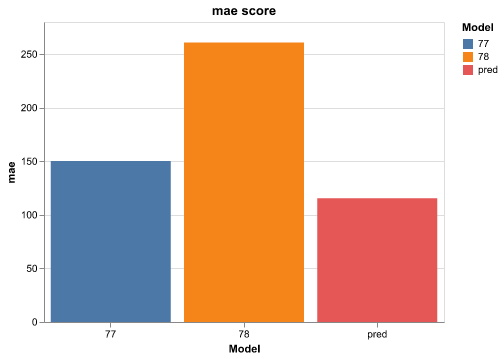

In [14]:
score.plot_mae()

To see the MSE error for your model (key = `pred`) and the other use: 

In [15]:
score.mse

{'pred': 39545.323650490725, '77': 69988.36318717948, '78': 166280.6349972801}

To plot a bar chart: 

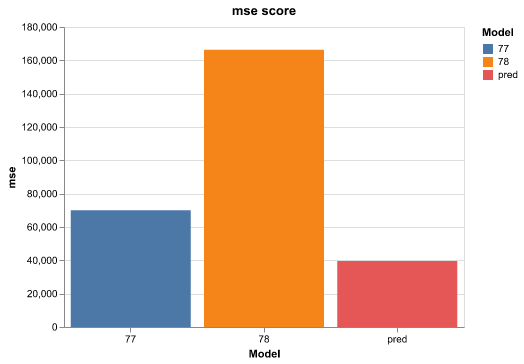

In [16]:
score.plot_mse()

To see the CRPS score for your model (key = `pred`) and the other, use the code below. The first dict contains the score by each point, and the second one shows the mean of the score.  

The CRPS score is computed using the formula below: 
$$
CRPS(\mathcal{N}(\mu_i, \sigma^2_i), y_i) = \sigma_i \left\{ \omega_i[\Phi(\omega_i) - 1] + 2\phi(\omega_i) - \frac{1}{\sqrt{\pi}}\right\},
$$

where $\Phi(\omega_i)$ and $\phi(\omega_i)$ is the cumulative distribution function (CDF) and the probability density function (PDF) of the standard normal distribution, respectively, evaluated at the normalized prediction error $\omega_i = \cfrac{y_i - \mu_i}{\sigma_i}$. Additionally, $y_i$ represents the cases observed in week $i$, $i$ is the mean forecasted value in week $i$ and $\sigma_i$ is the standard deviation of the forecast on week $i$.

To access the CRPS score use:

In [17]:
score.crps

({'pred': date
  2022-01-02     16.920249
  2022-01-09      9.999342
  2022-01-16     18.060801
  2022-01-23     15.087318
  2022-01-30      6.435420
                   ...    
  2023-05-28    397.491511
  2023-06-04    558.269619
  2023-06-11    717.722982
  2023-06-18    162.937319
  2023-06-25    265.386955
  Length: 78, dtype: float64,
  '77': date
  2022-01-02    104.558457
  2022-01-09     91.737919
  2022-01-16     40.233358
  2022-01-23     68.691104
  2022-01-30     62.889689
                   ...    
  2023-05-28    130.790086
  2023-06-04    745.026849
  2023-06-11    597.260235
  2023-06-18    151.757955
  2023-06-25    222.010512
  Length: 78, dtype: float64,
  '78': date
  2022-01-02     59.710708
  2022-01-09     31.950571
  2022-01-16     26.067532
  2022-01-23     28.236875
  2022-01-30     38.702663
                   ...    
  2023-05-28    363.596892
  2023-06-04    187.920326
  2023-06-11    466.297314
  2023-06-18    311.188335
  2023-06-25    419.705608
  Length

To plot the score you can use: 

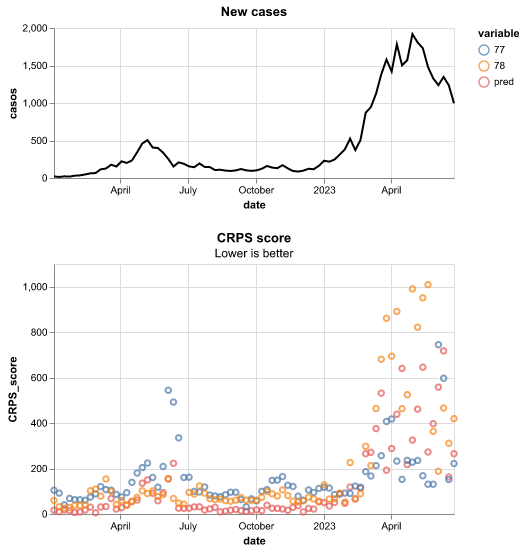

In [18]:
score.plot_crps()

To see the Log score for your model (key = `pred`) and the other, use the code below. The first dict contains the score by each point, and the second one shows the mean of the score. 

The Log score is computed using the formula below: 
$$
LogS(\mathcal{N}(\mu_i, \sigma^2_i), y_i) = log\left( \cfrac{\phi(\omega_i)}{\sigma_i}\right)
$$

To access the score use:

In [19]:
score.log_score

({'pred': date
  2022-01-02   -100.000000
  2022-01-09    -56.116588
  2022-01-16   -100.000000
  2022-01-23    -64.933527
  2022-01-30     -3.923909
                   ...    
  2023-05-28     -8.241205
  2023-06-04     -8.611541
  2023-06-11     -8.915073
  2023-06-18     -7.455601
  2023-06-25     -7.846381
  Length: 78, dtype: float64,
  '77': date
  2022-01-02   -7.012464
  2022-01-09   -6.890274
  2022-01-16   -6.066402
  2022-01-23   -6.600462
  2022-01-30   -6.514034
                  ...   
  2023-05-28   -7.034739
  2023-06-04   -9.349231
  2023-06-11   -8.475823
  2023-06-18   -7.299940
  2023-06-25   -7.345863
  Length: 78, dtype: float64,
  '78': date
  2022-01-02   -6.251962
  2022-01-09   -5.828483
  2022-01-16   -5.582020
  2022-01-23   -5.681777
  2022-01-30   -5.982782
                  ...   
  2023-05-28   -7.882657
  2023-06-04   -7.212958
  2023-06-11   -8.539122
  2023-06-18   -7.668388
  2023-06-25   -8.820387
  Length: 78, dtype: float64},
 {'pred': -10.0517204

To plot this score: 

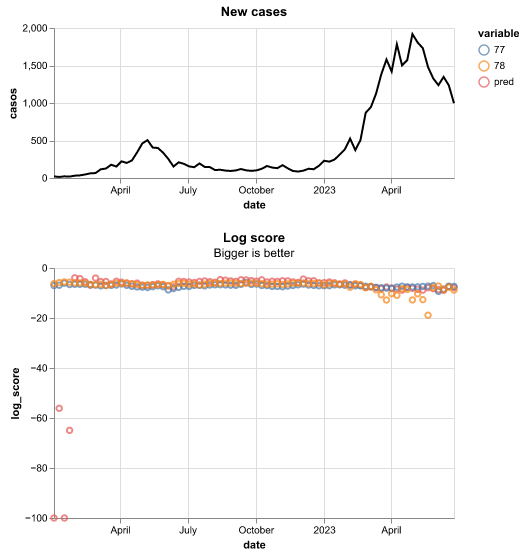

In [20]:
score.plot_log_score()

To see the Interval score for your model (key = `pred`) and the other, use the code below. The first dict contains the score by each point, and the second one shows the mean of the score. 

The Interval score is computed using the formula below: 

$$
S^{int}_\alpha(l_i, u_i; y_i) = u_i - l_i + \cfrac{2}{\alpha}(l_i - y_i)I\{y_i < l_i\} + \cfrac{2}{\alpha}(y_i - u_i)I\{y_i > u_i\}
$$

where $I$ is the indicator function, $\alpha$ the significance level of the interval, $u_i$ the upper value of the interval at week $i$ and $l_i$ the lower value. 

To access the score use:

In [21]:
score.interval_score

({'pred': date
  2022-01-02      618.769409
  2022-01-09      324.654790
  2022-01-16      625.118258
  2022-01-23      485.216510
  2022-01-30       24.942316
                    ...     
  2023-05-28     5612.744052
  2023-06-04     8261.036224
  2023-06-11    11472.594022
  2023-06-18     2692.862342
  2023-06-25     3800.696000
  Length: 78, dtype: float64,
  '77': date
  2022-01-02    1729.224550
  2022-01-09    1535.870970
  2022-01-16     673.935178
  2022-01-23    1149.216706
  2022-01-30    1054.854137
                   ...     
  2023-05-28    1581.950329
  2023-06-04    5108.470039
  2023-06-11    2253.660246
  2023-06-18    2215.129540
  2023-06-25    1599.324556
  Length: 78, dtype: float64,
  '78': date
  2022-01-02     723.852005
  2022-01-09     529.594919
  2022-01-16     406.103091
  2022-01-23     452.769243
  2022-01-30     607.853487
                   ...     
  2023-05-28    1591.534662
  2023-06-04    1529.045267
  2023-06-11    1364.866417
  2023-06-18    1643

To visualise a plot with the score use:

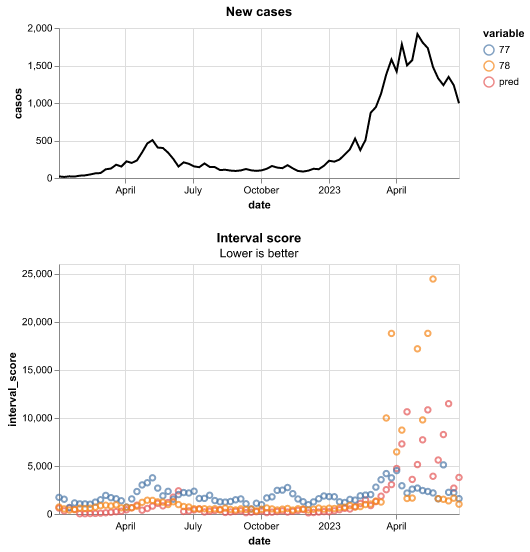

In [22]:
score.plot_interval_score()

To generate a table with a summary of the scores, you can use the following: 

In [23]:
score.summary

,mae,mse,crps,log_score,interval_score
id,,,,,
pred,115.525008,39545.323650,123.236279,-10.051720,1572.304476
77,150.218462,69988.363187,157.674777,-7.153337,1951.455378
78,260.983184,166280.634997,194.357799,-7.185720,2171.979336


To generate a plot of the predictions, you can use the following: 

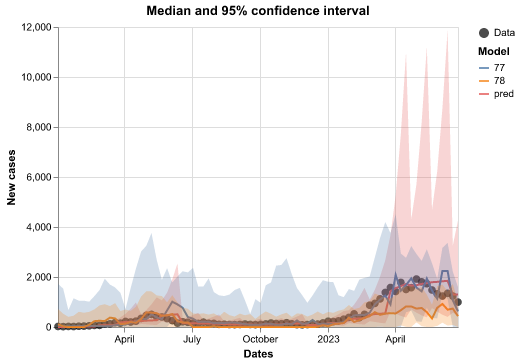

In [24]:
score.plot_predictions()

The class will select the bigger range of dates that contains information about each prediction dataframe. If you want to see the model's performance in a lower range, use the method below. The new range of dates provided must be between `score.min_date` and `score.max_date`. Otherwise, it will return an error.

In [25]:
score.set_date_range(start_date = '2023-01-01', end_date='2023-06-01' )

In this case:

In [26]:
score.summary

,mae,mse,crps,log_score,interval_score
id,,,,,
pred,224.814969,90991.537676,267.927485,-7.438344,3386.763068
77,204.412273,76788.430632,181.400956,-7.339383,2395.203817
78,588.199306,506643.235469,455.204788,-9.116892,5840.958906


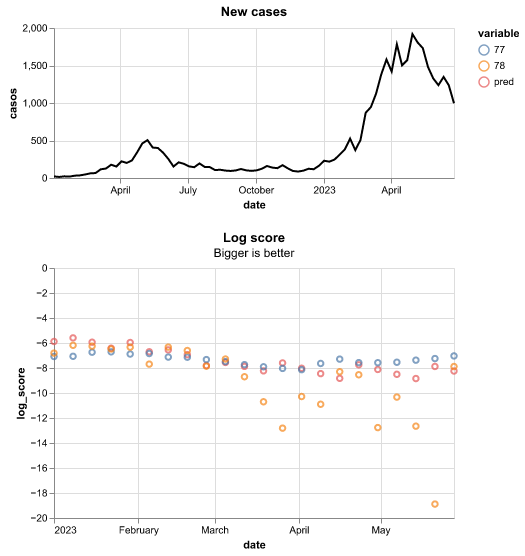

In [27]:
score.plot_log_score()

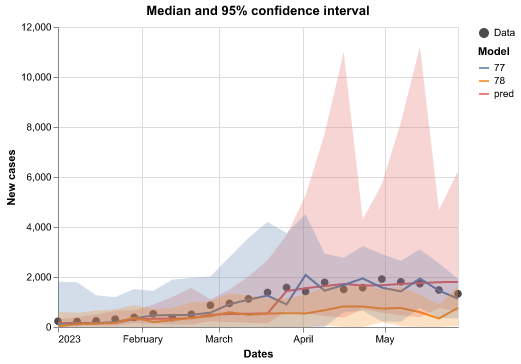

In [28]:
score.plot_predictions()